<a href="https://colab.research.google.com/github/c-walls/Essay-Score-Predictions/blob/main/LGBM_CV%2BFeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S R
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

DATA_SOURCE_MAPPING = 'linking-writing-processes-to-writing-quality:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F59291%2F6678907%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240328%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240328T011553Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2cf3263882945d2d403d09c82a02c03f75e99d9dc23517fa32d55d8642dd75b7c15904130575a0d5399c9362095593fc7ee2c632d990a65469101e939d2fd06467312b94a53ccad9541b6d6ebea4976033512121b716d0cde5d566cfb2d3feb0b8dc34494577e76263aaabe6a9cca3d23cb3b1f581f39311e1133a9773b7d4d520ba8af3bd590412f3de5ebb181a3ccf81f7874ed4cbefe5989e3071eeb7841aeeb1a90e480de9bfce9f45553b5c0655051d61c7bde4ade586f5e3633a034d923af63efc8d1b274462fc32db1ed3bf15e477b05c77dac5f3cc1177b1a6aacc96330b31e77bcb4bff862632abd56213e040dc306e9f4a44a03f713bac6afbfd72'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'

system(paste0('sudo umount ', '/kaggle/input'))
system(paste0('sudo rmdir ', '/kaggle/input'))
system(paste0('sudo mkdir -p -- ', KAGGLE_INPUT_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_INPUT_PATH), intern=TRUE)
system(paste0('sudo ln -sfn ', KAGGLE_INPUT_PATH,' ',file.path('..', 'input')), intern=TRUE)
system(paste0('sudo mkdir -p -- ', KAGGLE_WORKING_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_WORKING_PATH), intern=TRUE)
system(paste0('sudo ln -sfn ', KAGGLE_WORKING_PATH, ' ', file.path('..', 'working')), intern=TRUE)

data_source_mappings = strsplit(DATA_SOURCE_MAPPING, ',')[[1]]
for (data_source_mapping in data_source_mappings) {
    path_and_url = strsplit(data_source_mapping, ':')
    directory = path_and_url[[1]][1]
    download_url = URLdecode(path_and_url[[1]][2])
    filename = sub("\\?.+", "", download_url)
    destination_path = file.path(KAGGLE_INPUT_PATH, directory)
    print(paste0('Downloading and uncompressing: ', directory))
    if (endsWith(filename, '.zip')){
      temp = tempfile(fileext = '.zip')
      download.file(download_url, temp)
      unzip(temp, overwrite = TRUE, exdir = destination_path)
      unlink(temp)
    }
    else{
      temp = tempfile(fileext = '.tar')
      download.file(download_url, temp)
      untar(temp, exdir = destination_path)
      unlink(temp)
    }
    print(paste0('Downloaded and uncompressed: ', directory))
}

print(paste0('Data source import complete'))

character(0)

character(0)

character(0)

character(0)

character(0)

character(0)

[1] "Downloading and uncompressing: linking-writing-processes-to-writing-quality"
[1] "Downloaded and uncompressed: linking-writing-processes-to-writing-quality"
[1] "Data source import complete"


In [2]:
install.packages("moments")
install.packages("caTools")
install.packages("lightgbm")
install.packages("caret")

library(moments)
library(ggplot2)
library(caTools)
library(lightgbm)
library(readr)
library(caret)

train_scores <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv")
train_logs <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv")
sample_submission <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv")
test_logs <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv")
test_scores <- data.frame(id = unique(test_logs$id))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘bitops’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lattice



# DATA CLEANING

In [3]:
data_cleaning <- function(logs) {

  #Combine Event Columns
  logs <- logs[, names(logs) != "up_event"]
  names(logs)[names(logs) == "down_event"] <- "event"

  #Simplify Move Activities
  tryCatch ({
      logs[substr(logs$activity, 1, 1) == "M", ]$text_change <- strsplit(logs[substr(logs$activity, 1, 1) == "M", ]$activity, " From ")[[1]][2]
      logs[substr(logs$activity, 1, 1) == "M", ]$activity <- "Move"
  }, error = function(e) {
      cat("Error reformatting MOVE activities:\n", conditionMessage(e), "\n")
  })

  #Remove extra movement info from 'undo' rows & convert to factor
  logs$activity <- as.factor(logs$activity)
  str(logs$activity)


  #Simplify Event Values
  logs$event <- gsub("(?i)(F[0-9]{1,2}|.*Media.*|.*Audio.*|.*Pause.*).*", "DeviceFeatureChangeKey", logs$event)
  logs$event <- gsub("(?i)(Scroll.*|Meta|Dead|Process|OS|AltGraph|Mode.*)", "SpecialProcessKey", logs$event)
  logs$event <- gsub("(?i)(Clear|Cancel)", "Escape", logs$event)
  logs$event <- gsub("^[0-9]$", "DigitKey", logs$event)
  logs$event <- gsub("(?i).*Arrow.*", "ArrowKey", logs$event)
  logs$event <- gsub("(?i)(Home|End|^Page.*)", "TextJumpKey", logs$event)

  #Compile list of allowed event values
  event_labels <- c("^[A-Za-z]$", "^[[:punct:]]$", "click", "Shift", "Space", "Backspace", "Enter", "Tab", "Caps", "Control", "Delete", "Insert", "Escape", "Print", "RareKey", "NumLock", "Alt", "ContextMenu", "ArrowKey", "TextJumpKey", "DeviceFeatureChangeKey", "SpecialProcessKey", "DigitKey", "Unidentified")
  valid_events <- unique(logs$event)[apply(sapply(event_labels, function(x) grepl(x, unique(logs$event))), 1, any)]

  #Replace remaining event values with "Unidentified"
  cat("\n", "\n", "INVALID VALUES: ")
  print(table(logs$event, exclude = valid_events))
  logs$event <- ifelse(logs$event %in% valid_events, logs$event, "Unidentified")

  cat("\n", "RARE VALUES: ")
  print(names(which(table(logs$event) < 25)))
  logs$event[logs$event %in% names(which(table(logs$event) < 25))] <- "RareKey"

  cat("\n", "REMAINING VALUES: ")
  print(unique(logs$event))
  cat("Total 'Event' Values: ", length(unique(logs$event)))

  #Convert event variable to factor and check
  logs$event <- as.factor(logs$event)
  str(logs$event)

  return(logs)
}

train_logs <- data_cleaning(train_logs)

 Factor w/ 6 levels "Input","Move",..: 3 3 3 1 1 1 1 1 1 1 ...

 
 INVALID VALUES: 
       \u0096        \u009b        \u0097        \u0080 â\u0080\u0093 
            2             1            14             1             4 
      Å\u009f             ä            Â´            Ä±       Ë\u0086 
            1             1             1             3             1 

 RARE VALUES:  [1] "_"            "¡"            "¿"            "{"            "}"           
 [6] "@"            "#"            "`"            "^"            "|"           
[11] "~"            "A"            "b"            "C"            "d"           
[16] "e"            "f"            "F"            "g"            "h"           
[21] "i"            "I"            "j"            "l"            "m"           
[26] "M"            "Middleclick"  "n"            "o"            "p"           
[31] "r"            "S"            "t"            "T"            "u"           
[36] "Unknownclick" "V"            "w"            "y"    

# FEATURE ENGINEERING

In [4]:
create_features <- function(logs, scores) {

  total_events <- function(logs, scores) {
    result <- aggregate(event_id ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "event_id"] <- "total_events"
    return(result)
  }

  event_diversity <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) length(unique(x)))
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "event_diversity"
    return(result)
  }

  normalized_event_diversity <- function(scores) {
    scores$normalized_event_diversity <- scores$event_diversity / scores$total_events
    return(scores)
  }

  submitted_words <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = function(x) tail(x, 1))
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "submitted_words"
    return(result)
  }

  submission_complexity <- function(scores) {
    scores$submission_complexity <- scores$submitted_words / scores$total_events
    return(scores)
  }

  max_words <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "max_words"
    return(result)
  }

  word_reduction <- function(scores) {
    scores$word_reduction <- scores$max_words - scores$submitted_words
    return(scores)
  }

  word_count_mean <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = mean)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_mean"
    return(result)
  }

  word_count_sd <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = sd)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_sd"
    return(result)
  }

  word_count_skew <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = skewness)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_skew"
    return(result)
  }

  word_count_kurt <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = kurtosis)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_kurt"
    return(result)
  }

  word_count_median <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = median)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_median"
    return(result)
  }

  word_count_IQR <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = IQR)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_IQR"
    return(result)
  }

  submission_time <- function(logs, scores) {
    result <- aggregate(up_time ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "up_time"] <- "submission_time"
    return(result)
  }

  first_input <- function(logs, scores) {
    result <- aggregate(down_time ~ id, data = logs[logs$activity == "Input", ], FUN = min)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "down_time"] <- "first_input"
    return(result)
  }

  writing_time <- function(scores) {
    scores$writing_time <- scores$submission_time - scores$first_input
    return(scores)
  }

  submit_word_rate <- function(scores) {
    scores$submit_word_rate <- scores$submitted_words / scores$writing_time
    return(scores)
  }

  max_word_rate <- function(scores) {
    scores$max_word_rate <- scores$max_words / scores$writing_time
    return(scores)
  }

  normalized_cursor_position <- function(logs, scores) {
    logs <- merge(scores[ , c("id", "submitted_words")], logs, by = "id", all.x = TRUE)
    logs$normalized_cursor_position <- logs$cursor_position / logs$submitted_words
    return(logs)
  }

  cursor_position_mean <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = mean)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_mean"
    return(result)
  }

  cursor_position_sd <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = sd)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_sd"
    return(result)
  }

  cursor_position_skew <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = skewness)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_skew"
    return(result)
  }

  cursor_position_kurt <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = kurtosis)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_kurt"
    return(result)
  }

  cursor_position_median <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = median)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_median"
    return(result)
  }

  cursor_position_IQR <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = IQR)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_IQR"
    return(result)
  }

  cursor_position_max <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_max"
    return(result)
  }

  word_reduction <- function(scores) {
    scores$word_reduction <- scores$max_words - scores$submitted_words
    return(scores)
  }

  input_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Input"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "input_count"
    return(result)
  }

  cut_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Remove/Cut"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "cut_count"
    return(result)
  }

  paste_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Paste"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "paste_count"
    return(result)
  }

  move_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Move"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "move_count"
    return(result)
  }

  replace_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Replace"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "replace_count"
    return(result)
  }

  nonproduction_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Nonproduction"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "nonproduction_count"
    return(result)
  }

  input_frequency <- function(scores) {
    scores$input_frequency <- scores$input_count / scores$total_events
    return(scores)
  }

  nonproduction_frequency <- function(scores) {
    scores$nonproduction_frequency <- scores$nonproduction_count / scores$total_events
    return(scores)
  }

  cut_frequency <- function(scores) {
    scores$cut_frequency <- scores$cut_count / scores$total_events
    return(scores)
  }

  cut_input_ratio <- function(scores) {
    scores$cut_input_ratio <- scores$cut_count / scores$input_count
    return(scores)
  }

  input_rate <- function(scores) {
    scores$input_rate <- scores$input_count / scores$writing_time
    return(scores)
  }

  input_productivity <- function(scores) {
    scores$input_productivity <- scores$input_count / scores$submitted_words
    return(scores)
  }

  period_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "."))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "period_count"
    return(result)
  }

  comma_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == ","))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "comma_count"
    return(result)
  }

  punctuation_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "." | x == "," | x == "!" | x == "?" | x == ":" | x == ";"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "punctuation_count"
    return(result)
  }

  space_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Space"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "space_count"
    return(result)
  }

  enter_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Enter"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "enter_count"
    return(result)
  }

  deletion_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Delete" | x == "Backspace" | x == "c"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "deletion_count"
    return(result)
  }

  shift_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Shift"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "shift_count"
    return(result)
  }

  tab_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Tab"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "tab_count"
    return(result)
  }

  punctuation_frequency <- function(scores) {
    scores$punctuation_frequency <- scores$punctuation_count / scores$submitted_words
    return(scores)
  }

  deletion_frequency <- function(scores) {
    scores$deletion_frequency <- scores$deletion_count / scores$submitted_words
    return(scores)
  }

  shift_frequency <- function(scores) {
    scores$shift_frequency <- scores$shift_count / scores$submitted_words
    return(scores)
  }

  tab_frequency <- function(scores) {
    scores$tab_frequency <- scores$tab_count / scores$submitted_words
    return(scores)
  }

  enter_frequency <- function(scores) {
    scores$enter_frequency <- scores$enter_count / scores$submitted_words
    return(scores)
  }

  period_frequency <- function(scores) {
    scores$period_frequency <- scores$period_count / scores$submitted_words
    return(scores)
  }

  comma_frequency <- function(scores) {
    scores$comma_frequency <- scores$comma_count / scores$submitted_words
    return(scores)
  }

  space_frequency <- function(scores) {
    scores$space_frequency <- scores$space_count / scores$submitted_words
    return(scores)
  }

  scores <- total_events(logs, scores)
  scores <- event_diversity(logs, scores)
  scores <- normalized_event_diversity(scores)
  scores <- submitted_words(logs, scores)
  scores <- submission_complexity(scores)
  scores <- max_words(logs, scores)
  scores <- word_reduction(scores)
  scores <- word_count_mean(logs, scores)
  scores <- word_count_sd(logs, scores)
  scores <- word_count_median(logs, scores)
  scores <- word_count_IQR(logs, scores)
  scores <- word_count_skew(logs, scores)
  scores <- word_count_kurt(logs, scores)
  scores <- submission_time(logs, scores)
  scores <- first_input(logs, scores)
  scores <- writing_time(scores)
  scores <- submit_word_rate(scores)
  scores <- max_word_rate(scores)
  logs <- normalized_cursor_position(logs, scores)
  scores <- cursor_position_mean(logs, scores)
  scores <- cursor_position_sd(logs, scores)
  scores <- cursor_position_median(logs, scores)
  scores <- cursor_position_IQR(logs, scores)
  scores <- cursor_position_skew(logs, scores)
  scores <- cursor_position_kurt(logs, scores)
  scores <- cursor_position_max(logs, scores)
  scores <- input_count(logs, scores)
  scores <- cut_count(logs, scores)
  scores <- paste_count(logs, scores)
  scores <- move_count(logs, scores)
  scores <- nonproduction_count(logs, scores)
  scores <- replace_count(logs, scores)
  scores <- input_frequency(scores)
  scores <- nonproduction_frequency(scores)
  scores <- cut_frequency(scores)
  scores <- cut_input_ratio(scores)
  scores <- input_rate(scores)
  scores <- input_productivity(scores)
  scores <- period_count(logs, scores)
  scores <- comma_count(logs, scores)
  scores <- punctuation_count(logs, scores)
  scores <- space_count(logs, scores)
  scores <- enter_count(logs, scores)
  scores <- deletion_count(logs, scores)
  scores <- shift_count(logs, scores)
  scores <- tab_count(logs, scores)
  scores <- punctuation_frequency(scores)
  scores <- deletion_frequency(scores)
  scores <- shift_frequency(scores)
  scores <- tab_frequency(scores)
  scores <- enter_frequency(scores)
  scores <- period_frequency(scores)
  scores <- comma_frequency(scores)
  scores <- space_frequency(scores)

  return(scores)
}

train_scores <- create_features(train_logs, train_scores)

cat("\n", "LOG VARIABLES:", "\n")
print(names(train_logs))
cat("\n", "\n", "SCORE VARIABLES:", "\n")
print(names(train_scores))


 LOG VARIABLES: 
 [1] "id"              "event_id"        "down_time"       "up_time"        
 [5] "action_time"     "activity"        "event"           "text_change"    
 [9] "cursor_position" "word_count"     

 
 SCORE VARIABLES: 
 [1] "id"                         "cursor_position_max"       
 [3] "cursor_position_kurt"       "cursor_position_skew"      
 [5] "cursor_position_IQR"        "cursor_position_median"    
 [7] "cursor_position_sd"         "cursor_position_mean"      
 [9] "first_input"                "submission_time"           
[11] "word_count_kurt"            "word_count_skew"           
[13] "word_count_IQR"             "word_count_median"         
[15] "word_count_sd"              "word_count_mean"           
[17] "max_words"                  "submitted_words"           
[19] "event_diversity"            "total_events"              
[21] "score"                      "normalized_event_diversity"
[23] "submission_complexity"      "word_reduction"            
[25] "wri

# PREDICTIVE MODELING - LGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11348
[LightGBM] [Info] Number of data points in the train set: 2163, number of used features: 53
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11348
[LightGBM] [Info] Number of data points in the train set: 2162, number of used features: 53
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11348
[LightGBM] [Info] Number of data points in the train set: 2162, number of used features: 53
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002363 seconds.
You can set `force_col_wise=t

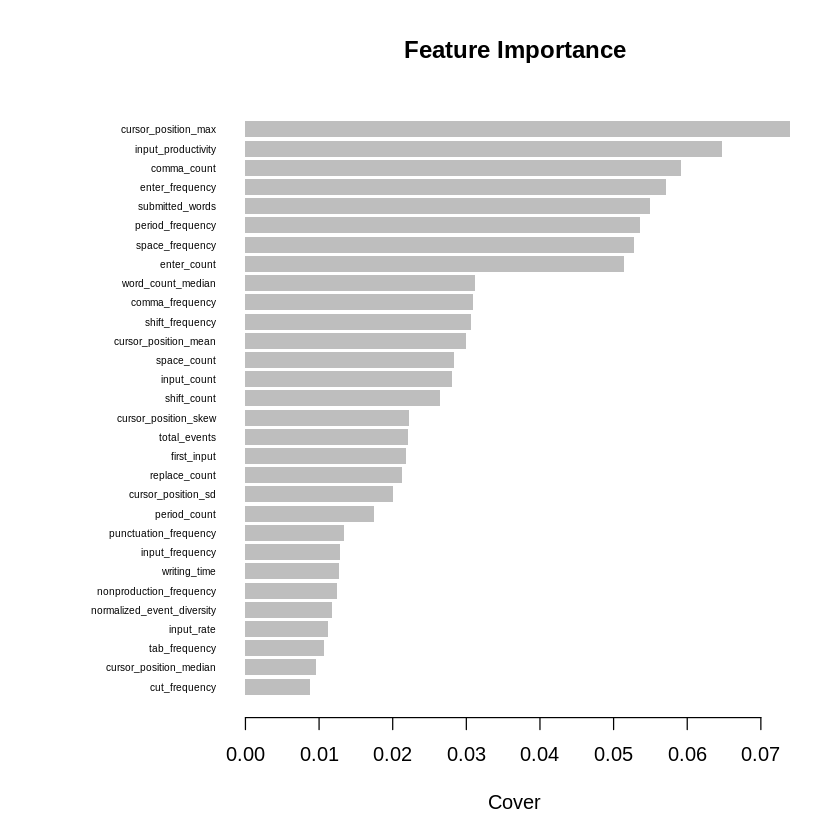

In [5]:
# Convert data to lightgbm dataset format
train_data <- lightgbm::lgb.Dataset(data = as.matrix(train_scores[, !(names(train_scores) %in% c("score", "id"))]), label = train_scores$score)

# Set up LGBM parameters
train_params <- list(
    objective = "regression",
    metric = "rmse",
    boosting_type = "gbdt",
    #n_estimators = 10000,
    num_leaves = 14,
    learning_rate = 0.05,
    feature_fraction = 0.83,
    nthread = 6
)

# Cross-Validation
set.seed(123)
cv_results <- lightgbm::lgb.cv(
    params = train_params,
    data = train_data,
    nrounds = 250,
    stratified = TRUE,
    nfold = 8
)
print(cv_results)

# Train LGBM Model
classifier_LGBM <- lightgbm::lgb.train(
    params = train_params,
    data = train_data,
    nrounds = cv_results$best_iter
)

# Plot feature importance
importance <- lgb.importance(classifier_LGBM, percentage = TRUE)[order(Cover, decreasing = TRUE), ]
print(importance[1:30])
lgb.plot.importance(importance, top_n = 30, measure = "Cover")

# FEATURE SELECTION

In [6]:
# Final Feature Selection
top_features <- as.matrix(train_scores[, importance$Feature[1:30]])
top_features_df <- lightgbm::lgb.Dataset(data = top_features, label = train_scores$score)

# Cross-Validation with top features only
set.seed(123)
cv_results <- lightgbm::lgb.cv(
    params = train_params,
    data = top_features_df,
    nrounds = 250,
    stratified = TRUE,
    nfold = 10
)
print(cv_results)

# Re-train on top features only
classifier_LGBM <- lightgbm::lgb.train(
    params = train_params,
    data = top_features_df,
    nrounds = cv_results$best_iter
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6803
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6803
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6803
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true

# PREPPING THE TEST SET

In [7]:
test_logs <- data_cleaning(test_logs)
test_scores <- create_features(test_logs, test_scores)

cat("\n", "\n", "TRAIN_SCORES VARIABLES:", "\n")
print(names(train_scores))

cat("\n", "\n", "TEST_SCORES VARIABLES:", "\n")
print(names(test_scores))

print(classifier_LGBM)

test_scores[test_scores == "NaN"] <- 0
test_scores[test_scores == "Inf"] <- 0
test_scores[is.na(test_scores)] <- 0

Error reformatting MOVE activities:
 subscript out of bounds 
 Factor w/ 1 level "Input": 1 1 1 1 1 1

 
 INVALID VALUES: < table of extent 0 >

 RARE VALUES: [1] "q"     "Space"

 REMAINING VALUES: [1] "RareKey"
Total 'Event' Values:  1 Factor w/ 1 level "RareKey": 1 1 1 1 1 1

 
 TRAIN_SCORES VARIABLES: 
 [1] "id"                         "cursor_position_max"       
 [3] "cursor_position_kurt"       "cursor_position_skew"      
 [5] "cursor_position_IQR"        "cursor_position_median"    
 [7] "cursor_position_sd"         "cursor_position_mean"      
 [9] "first_input"                "submission_time"           
[11] "word_count_kurt"            "word_count_skew"           
[13] "word_count_IQR"             "word_count_median"         
[15] "word_count_sd"              "word_count_mean"           
[17] "max_words"                  "submitted_words"           
[19] "event_diversity"            "total_events"              
[21] "score"                      "normalized_event_diversity"

# MAKE PREDICTIONS

In [8]:
test_predictions <- predict(classifier_LGBM, as.matrix(test_scores[, importance$Feature[1:30]]))
sample_submission <- data.frame(id = test_scores$id, score = test_predictions)
write_csv(sample_submission, "submission.csv")